<a href="https://colab.research.google.com/github/reubyTuesday/Math509RealEstate/blob/main/USA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_openml


Populating the interactive namespace from numpy and matplotlib


#Importing and Cleaning the Data

In [2]:
!pip install kaggle
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset


Dataset URL: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset
License(s): other
 73% 28.0M/38.2M [00:00<00:00, 145MB/s]
100% 38.2M/38.2M [00:00<00:00, 149MB/s]


In [3]:
!ls
!unzip usa-real-estate-dataset.zip


sample_data  usa-real-estate-dataset.zip
Archive:  usa-real-estate-dataset.zip
  inflating: realtor-data.zip.csv    


## Functions

1. Delete Missing Values
2.



In [4]:
# Function to drop missing values
def drop_missing(grp_col, col_to_check):
    nan_count_before = df[col_to_check].isna().sum()
    df.dropna(subset=[col_to_check], inplace=True)
    nan_count_after = df[col_to_check].isna().sum()

    print(f"Dropped {nan_count_before - nan_count_after} missing values from {col_to_check}.")

# Function to calculate missing values and percentage
## Code from Kaggle: https://www.kaggle.com/code/shaswotj/smart-price-prediction-using-ml
def missing_percentage(data_set):
    total_records = data_set.shape[0]
    missing_counts = data_set.isna().sum()
    missing_percentage = round(missing_counts / total_records * 100, 2)

    missing_summary = pd.DataFrame({
        'Missing Records': missing_counts,
        'Percentage Missing': missing_percentage
    })

    print(f"\nTotal number of records present: {total_records}\n")
    print(missing_summary.sort_values(by='Percentage Missing', ascending=False))
    print("\n")

# Function to imupute missing values with median
def imputer(grp_col,col_to_impute):
    imputer_df = round(df.groupby(grp_col)[col_to_impute].median(),0)
    df['helper_col'] = df[grp_col].map(imputer_df)

    nan_count_before = df[col_to_impute].isna().sum()

    df[col_to_impute] = df[col_to_impute].fillna(df['helper_col'])

    nan_count_after = df[col_to_impute].isna().sum()
    records_affected = nan_count_before - nan_count_after

    df.drop(columns = 'helper_col',inplace = True)
    print(f"Total records imputed for {col_to_impute}: {records_affected}")

In [5]:
# For example, if you have a CSV file named "real_estate.csv":
df = pd.read_csv('realtor-data.zip.csv')

## Drop Missing Values
drop_missing('zip_code','bed')
drop_missing('zip_code','bath')
drop_missing('zip_code','house_size')
drop_missing('zip_code','acre_lot')
drop_missing('zip_code','price')

# Impute missing values of bed, bath, house_size, acre_lot and price using zip_code
# I am not sure exactly how we want to impute these so I am not going to run this code for now.
#imputer('zip_code','bed')
#imputer('zip_code','bath')
#imputer('zip_code','house_size')
#imputer('zip_code','acre_lot')
#imputer('zip_code','price')

###Adjusting the 'status' to dummy variable
# Remove 'ready_to_build' entries
df = df[df['status'] != 'ready_to_build']

# Convert 'for_sale' to 0 and 'sold' to 1
df['status'] = df['status'].map({'for_sale': 0, 'sold': 1})

df_cleaned = df.copy()




Dropped 481317 missing values from bed.
Dropped 39959 missing values from bath.
Dropped 99039 missing values from house_size.
Dropped 244826 missing values from acre_lot.
Dropped 525 missing values from price.


In [6]:
#Quick reset of data frame
df = df_cleaned.copy()

In [7]:
### Use Target Encoding for Zip Code - Using Media because very expensive house could have a huge impact
zip_price_map = df.groupby('zip_code')['price'].median()
df['zip_code_encoded'] = df['zip_code'].map(zip_price_map)

print(f"Unique zip codes in original data: {df['zip_code'].nunique()}")
print(f"Unique zip codes after encoding: {df['zip_code_encoded'].nunique()}")


#Some of the zip codes may share the same mean house price.

Unique zip codes in original data: 27985
Unique zip codes after encoding: 6161


In [8]:
### Use Target Encoding for Street - Using Media because very expensive house could have a huge impact
street_price_map = df.groupby('street')['price'].median()
df['street_encoded'] = df['street'].map(street_price_map)

print(f"Unique streets in original data: {df['street'].nunique()}")
print(f"Unique streets after encoding: {df['street_encoded'].nunique()}")

#Many of the street may share the same mean house price.

Unique streets in original data: 1248329
Unique streets after encoding: 66652


## Double Checking our Encoding Worked

In [9]:
# Compute the mean price per street
street_price_map = df.groupby('street')['price'].median()

# Group by the mean price and list all streets sharing that mean
duplicates = (street_price_map
              .reset_index()
              .groupby('price')['street']
              .apply(list)
              .reset_index())

# Filter only entries where multiple streets share the same mean price
duplicates = duplicates[duplicates['street'].apply(len) > 1]

print(duplicates)


             price                                             street
1              1.0  [6043.0, 59436.0, 76439.0, 76549.0, 81643.0, 1...
9           1000.0  [214409.0, 391809.0, 601108.0, 1286877.0, 1710...
14          2000.0                              [884795.0, 1875919.0]
16          2500.0  [360439.0, 368694.0, 370012.0, 759871.0, 10645...
25          3500.0                               [128366.0, 292044.0]
...            ...                                                ...
66622   60000000.0       [1239414.0, 1246311.0, 1336562.0, 1666094.0]
66625   65000000.0  [97719.0, 296887.0, 794477.0, 868377.0, 998140.0]
66629   75000000.0                                [54568.0, 869383.0]
66631   78000000.0                               [101589.0, 101623.0]
66643  100000000.0  [213864.0, 484175.0, 561386.0, 1721324.0, 1887...

[17816 rows x 2 columns]


In [10]:
street_to_check = [213864.0, 484175.0, 561386.0, 1721324.0]
df_cleaned[df_cleaned['street'].isin(street_to_check)]

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
42460,29028.0,0,100000000.0,10.0,10.0,60.92,561386.0,Darien,Connecticut,6820.0,13107.0,NaN
1259167,NaN,0,100000000.0,11.0,16.0,2.69,213864.0,Beverly Hills,California,90210.0,27150.0,2015-08-18
1308027,78932.0,0,100000000.0,7.0,12.0,3600.00,1721324.0,Ojai,California,93023.0,25661.0,NaN
1322976,23592.0,0,100000000.0,5.0,5.0,8.00,484175.0,Atherton,California,94027.0,3731.0,NaN


## Looking at difference between sold and for-sale.

In [11]:
df.duplicated().sum()

df['status'].unique()

df.groupby('status')['price'].describe()


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,750933.0,623881.530485,2.908861e+06,0.0,239900.0,385000.0,625000.0,2.147484e+09
1,609783.0,514896.021662,6.987468e+05,1.0,237000.0,370000.0,589000.0,8.000000e+07


## Determine the Amount of Missing Values

From the results below we can see that there are a lot of missing values. So we need to determine what we do with this data.

In [12]:
# Checking missing values before imputing
## Code from Kaggle: https://www.kaggle.com/code/shaswotj/smart-price-prediction-using-ml
missing_percentage(df)


Total number of records present: 1360716

                  Missing Records  Percentage Missing
prev_sold_date             270807               19.90
street                       4025                0.30
street_encoded               4025                0.30
brokered_by                  2260                0.17
city                          326                0.02
zip_code_encoded               89                0.01
zip_code                       89                0.01
acre_lot                        0                0.00
bed                             0                0.00
price                           0                0.00
status                          0                0.00
bath                            0                0.00
state                           0                0.00
house_size                      0                0.00




## Only use Iowa for Initial analysis

In [13]:
print(df.columns)

# Create a new DataFrame with only North Dakota data
Iowa_df = df[df['state'] == 'Iowa']

# Display the first few rows to verify
print(Iowa_df.head())
print(Iowa_df.shape)

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date',
       'zip_code_encoded', 'street_encoded'],
      dtype='object')
        brokered_by  status      price  bed  bath  acre_lot     street  \
768546      16143.0       0   890000.0  5.0   5.0      4.91  1957724.0   
768549      95190.0       0    29000.0  2.0   1.0      0.25   810802.0   
768550      81618.0       0  1100000.0  4.0   3.0     20.02   537942.0   
768551      79025.0       0   236850.0  3.0   3.0     14.85   244509.0   
768552      93536.0       0   199900.0  3.0   1.0      0.50   932801.0   

                city state  zip_code  house_size prev_sold_date  \
768546      Ackworth  Iowa   50001.0      3292.0            NaN   
768549  New Virginia  Iowa   50210.0      1142.0     1995-07-05   
768550          Milo  Iowa   50166.0      1891.0            NaN   
768551  New Virginia  Iowa   50210.0      2052.0     2016-09-08   
768552

In [14]:
data = Iowa_df.copy()

data.drop(columns=['state'], inplace=True)
# Display the entire dataset
print(data.describe())
data.shape

         brokered_by        status         price           bed          bath  \
count   16490.000000  16498.000000  1.649800e+04  16498.000000  16498.000000   
mean    60114.687811      0.475755  2.558436e+05      3.217178      2.274458   
std     27478.320802      0.499427  1.947396e+05      0.960859      1.002853   
min       211.000000      0.000000  1.000000e+00      1.000000      1.000000   
25%     38036.000000      0.000000  1.390000e+05      3.000000      2.000000   
50%     63619.000000      0.000000  2.170000e+05      3.000000      2.000000   
75%     81225.000000      1.000000  3.250000e+05      4.000000      3.000000   
max    110098.000000      1.000000  4.789860e+06     15.000000     15.000000   

           acre_lot        street      zip_code    house_size  \
count  16498.000000  1.649700e+04  16498.000000  16498.000000   
mean       2.486121  9.035991e+05  51017.972239   1642.665717   
std      110.376631  5.104484e+05   1027.927243    974.034648   
min        0.000000

(16498, 13)

In [15]:
##Remove Unnecessary Columns
data.drop(columns=['brokered_by', 'city', 'street', 'prev_sold_date', 'zip_code'], inplace=True)

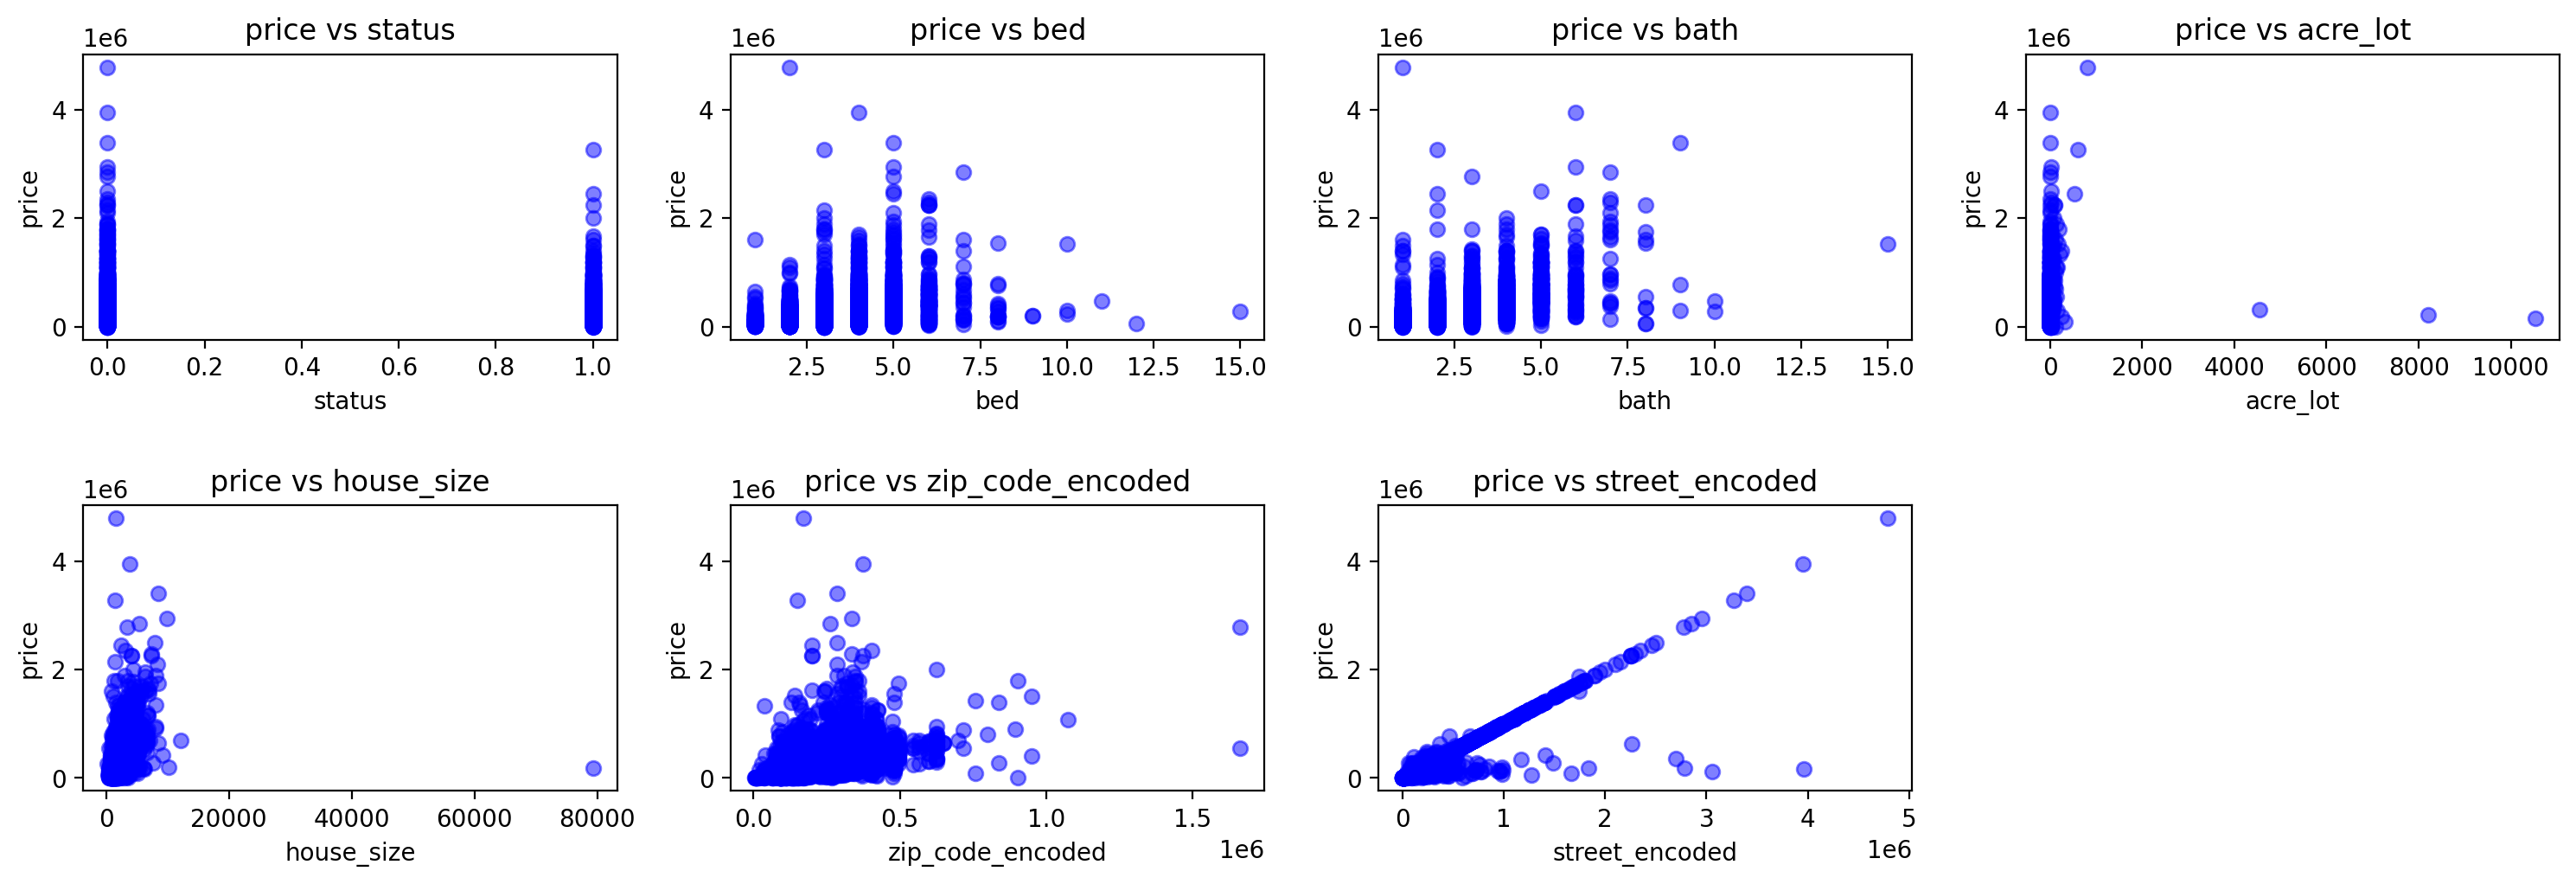

In [16]:
# Creating scatter plots

# Define the response variable (target)
y_response = data['price']

# Create scatter plots for each predictor against the target variable
predictor_cols = [col for col in data.columns if col != 'price']

plt.figure(figsize=(15, 10))  # Set figure size

for i, col in enumerate(predictor_cols):
    plt.subplot(4, 4, i + 1)
    plt.scatter(data[col], data['price'], color='blue', alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('price')
    plt.title(f'price vs {col}')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [17]:
# For acre_lot
lower_acre = data['acre_lot'].quantile(0.01)
upper_acre = data['acre_lot'].quantile(0.99)
data = data[(data['acre_lot'] >= lower_acre) & (data['acre_lot'] <= upper_acre)]

# For house_size
lower_size = data['house_size'].quantile(0.01)
upper_size = data['house_size'].quantile(0.99)
data = data[(data['house_size'] >= lower_size) & (data['house_size'] <= upper_size)]

# For Price
lower_price = data['price'].quantile(0.01)
upper_price = data['price'].quantile(0.99)
data = data[(data['price'] >= lower_price) & (data['price'] <= upper_price)]



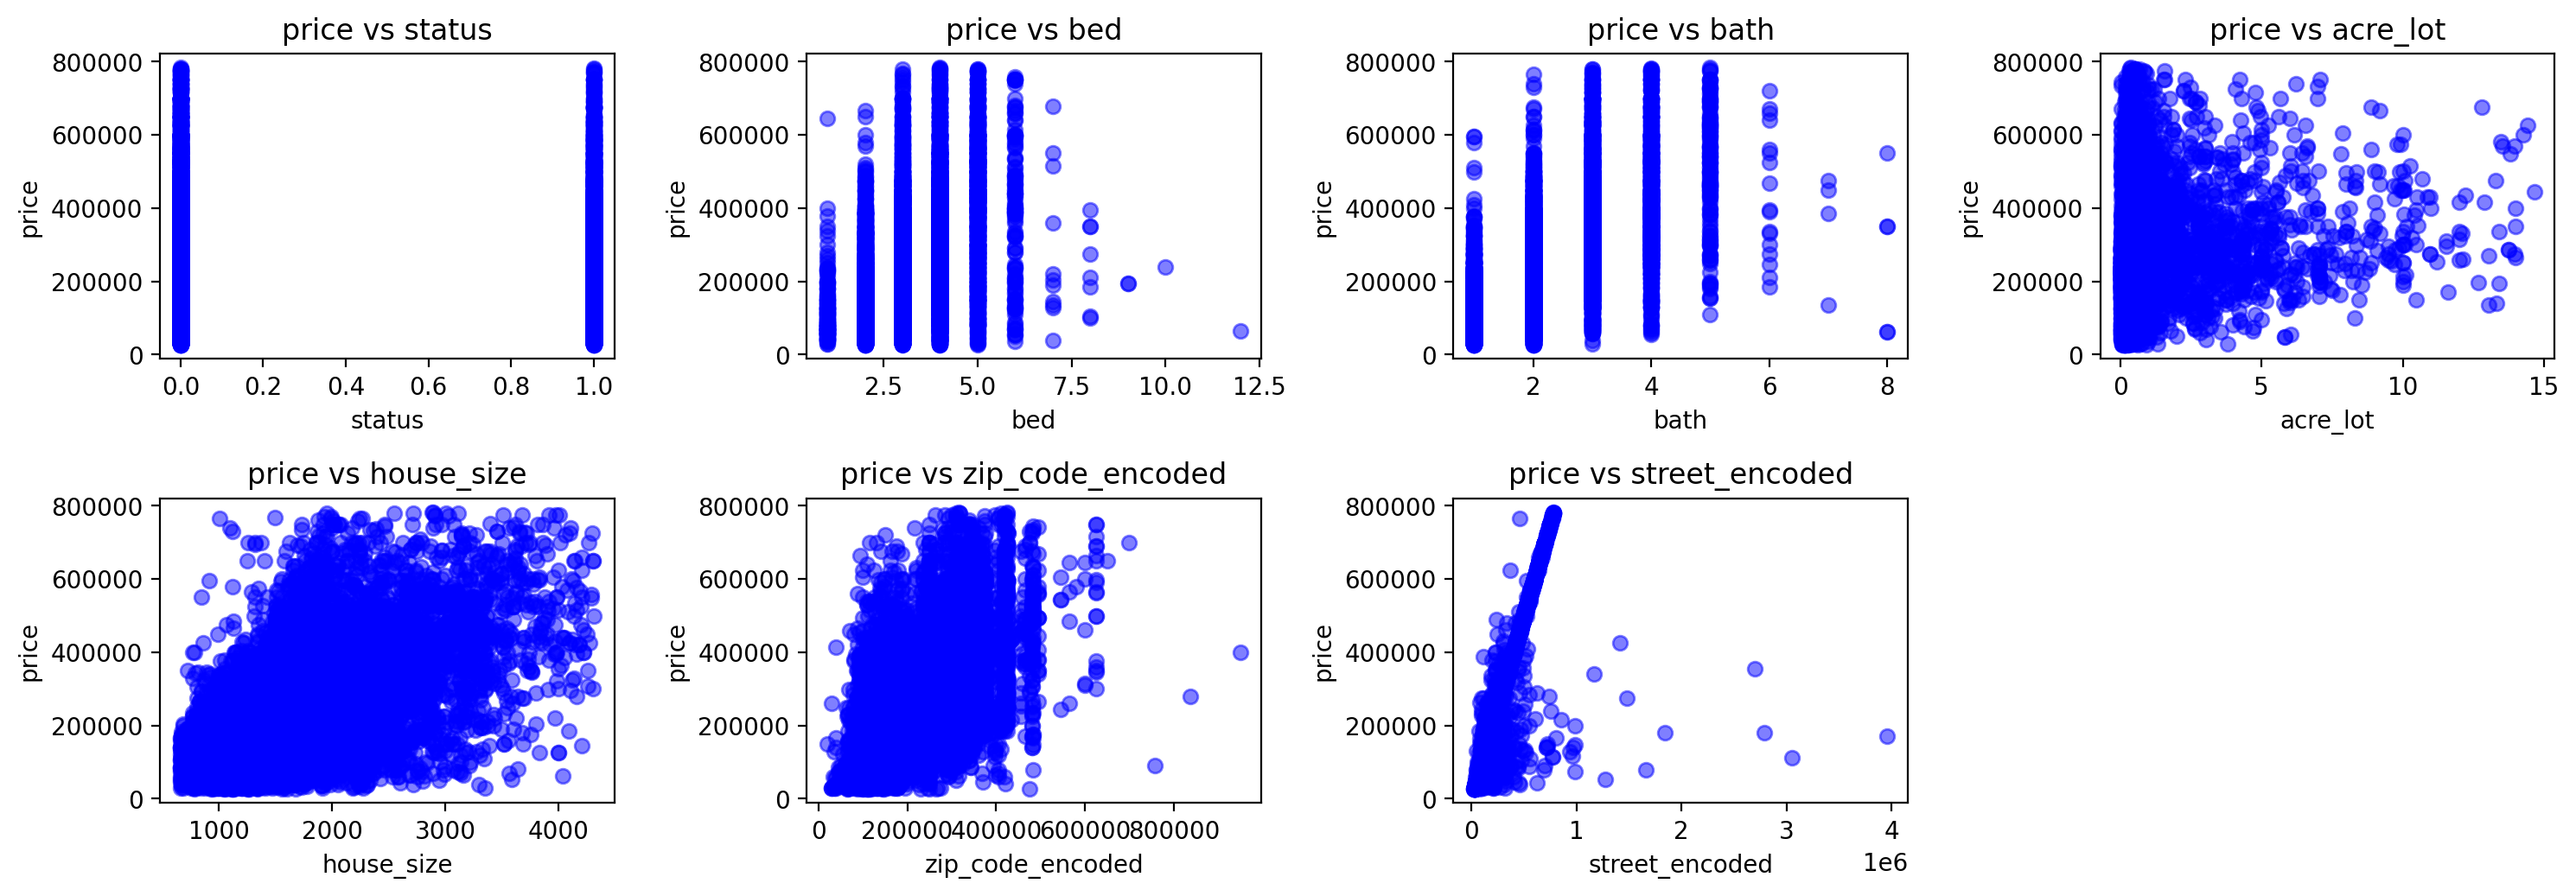

In [18]:
# Creating scatter plots

# Define the response variable (target)
y_response = data['price']

# Create scatter plots for each predictor against the target variable
predictor_cols = [col for col in data.columns if col != 'price']

# Create scatter plots for each predictor against the target variable
plt.figure(figsize=(15, 10))  # Set figure size


for i, col in enumerate(predictor_cols):  # Exclude price from predictors
    plt.subplot(4, 4, i + 1)  # Create subplots in a 4x4 grid
    plt.scatter(data[col], y_response, color='blue', alpha=0.5)  # Set blue color
    plt.xlabel(col)
    plt.ylabel('price')
    plt.title(f'price vs {col}')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

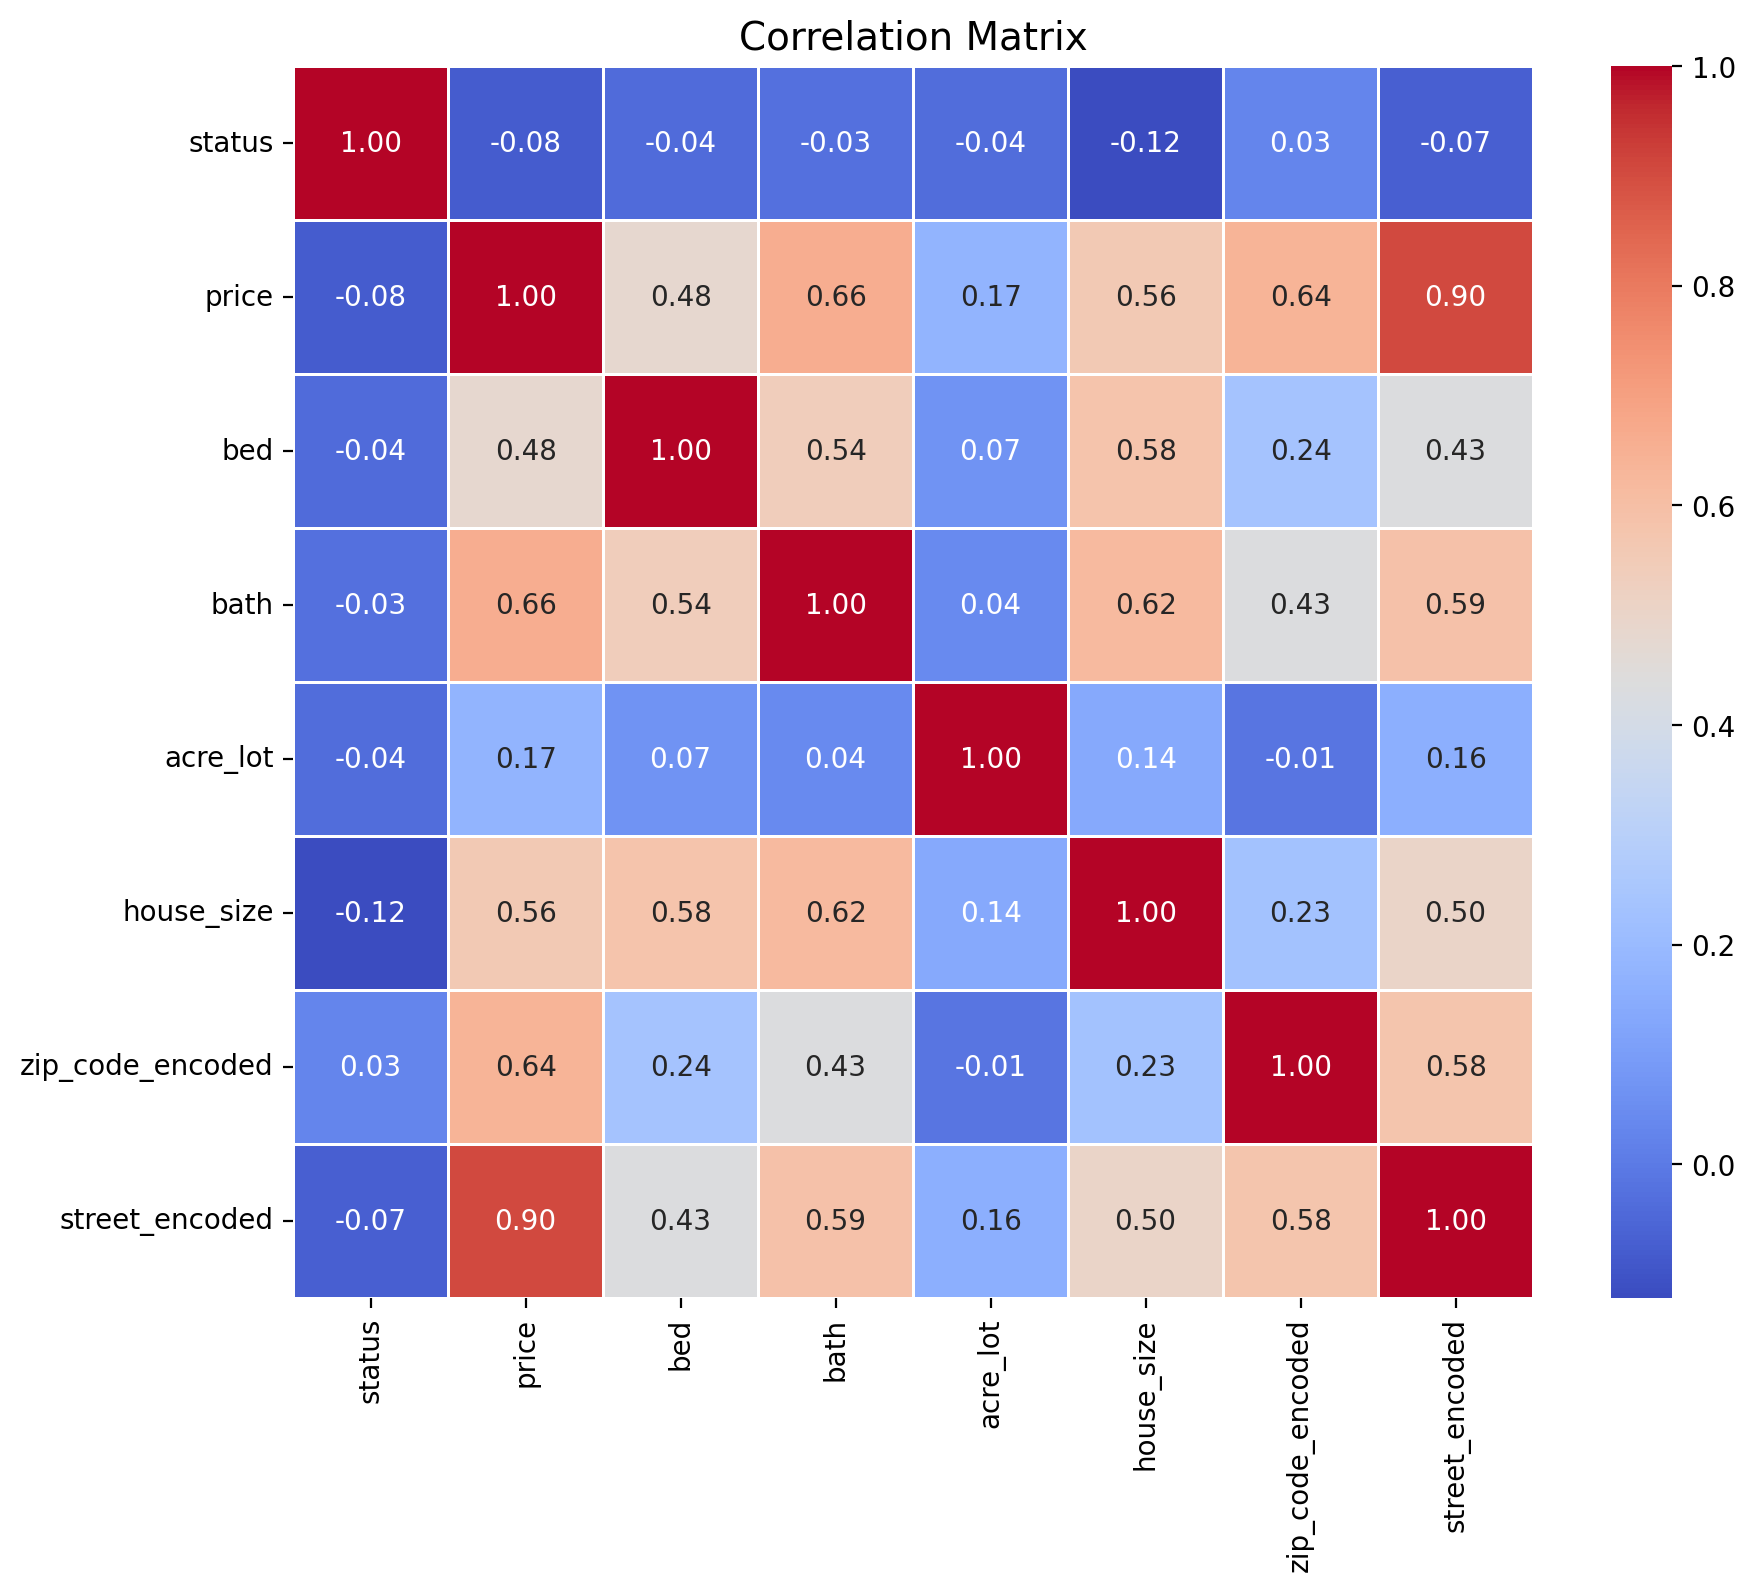

In [19]:
# Import the seaborn library
import seaborn as sns

# Compute the correlation matrix
corr_matrix = data.corr()

# Display correlation matrix
# print(corr_matrix)

# Set figure size for better readability
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Set title
plt.title("Correlation Matrix", fontsize=14)

# Show the plot
plt.show()

##Remove Street Encoded

In [20]:
##Remove Unnecessary Columns
data.drop(columns=['street_encoded'], inplace=True)


## Split and Standardize Data

In [21]:
# Import the necessary function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Set the random seed for reproducibility
np.random.seed(934)

# Define X and y
X = data.drop('price', axis=1)  # Features (all columns except 'price')
y = data['price']  # Target variable

# Split the dataset into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=13000, random_state=934)

# Check the shapes of the train and validation sets
print(x_train.shape)
print(x_valid.shape)

# Standardize the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

print("Means:", np.mean(x_train_scaled, axis=0))
print("Stds:", np.std(x_train_scaled, axis=0))

(13000, 6)
(2590, 6)
Means: [-2.04964251e-17  1.17512837e-17  1.61511830e-16  9.83828403e-18
 -1.36779477e-16  4.48188495e-17]
Stds: [1. 1. 1. 1. 1. 1.]


## Standardizing and Winsorizing

In [22]:
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set the random seed for reproducibility
np.random.seed(934)

# Define X and y
X = data.drop('price', axis=1)  # Features (all columns except 'price')
y = data['price']               # Target variable

# Split the dataset into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=13000, random_state=934)

# Winsorize the data: cap the extreme 5% on each tail
x_train_winsorized = x_train.copy()
x_valid_winsorized = x_valid.copy()

lower_lim = 0.05  # lower tail percentage
upper_lim = 0.05  # upper tail percentage

for col in x_train.columns:
    x_train_winsorized[col] = winsorize(x_train[col], limits=(lower_lim, upper_lim))
    x_valid_winsorized[col] = winsorize(x_valid[col], limits=(lower_lim, upper_lim))

# Standardize the winsorized data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_winsorized)
x_valid_scaled = scaler.transform(x_valid_winsorized)

print("Means:", np.mean(x_train_scaled, axis=0))
print("Stds:", np.std(x_train_scaled, axis=0))


Means: [-2.04964251e-17  2.11523107e-16  1.46481118e-16  3.66202795e-17
  1.91573253e-16 -1.62878258e-16]
Stds: [1. 1. 1. 1. 1. 1.]


## Simple Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

#Initialize
lm1 = LinearRegression()

lm1.fit(x_train_scaled, y_train) #Fit the Model to the training data

y_pred = lm1.predict(x_valid_scaled) #Make Predictions on the validation set

# Print model coefficients
print("Coefficients:", lm1.coef_)
print("Intercept:", lm1.intercept_)

from sklearn.metrics import mean_squared_error

# Compute MSE for Ridge Prediction:
mse_valid_lm = mean_squared_error(y_valid, y_pred)

# Print results
print(f"Validation MSE: {mse_valid_lm:.4f}")

# R Squared
from sklearn.metrics import r2_score
r2 = r2_score(y_valid, y_pred)
print("R² Score:", r2)

# Adjusted R Squared
n = len(y_valid)
p = X.shape[1]  # number of features

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R²:", adjusted_r2)


Coefficients: [-7576.29702419 13649.80799788 38147.99785855 22875.63585593
 25047.71294149 61940.07517901]
Intercept: 242300.71676923076
Validation MSE: 6242009686.3675
R² Score: 0.6556751578240494
Adjusted R²: 0.6548753324066836


##Troubleshooting Model

In [24]:
from sklearn.metrics import mean_squared_error

# Naive: predict mean of y_train for all x_valid
y_mean = y_train.mean()
naive_preds = [y_mean] * len(y_valid)
naive_mse = mean_squared_error(y_valid, naive_preds)
print("Naive MSE:", naive_mse)


from sklearn.metrics import r2_score
r2 = r2_score(y_valid, y_pred)
print("R² Score:", r2)


n = len(y_valid)
p = X.shape[1]  # number of features

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R²:", adjusted_r2)

data.shape[1]

Naive MSE: 18134865118.35121
R² Score: 0.6556751578240494
Adjusted R²: 0.6548753324066836


7

## Ridge Regression


In [25]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Initialize and fit Ridge regression model
ridge = Ridge(alpha=1)  # You can adjust alpha (regularization strength)
ridge.fit(x_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge.predict(x_valid_scaled)

# Print coefficients

print("Ridge Coefficients:", ridge.coef_)

# Compute MSE for Ridge Prediction:
mse_valid_ridge = mean_squared_error(y_valid, y_pred_ridge)

# Print results
print(f"Validation MSE: {mse_valid_ridge:.4f}")

# R Squared
from sklearn.metrics import r2_score
r2 = r2_score(y_valid, y_pred_ridge)
print("R² Score:", r2)

# Adjusted R Squared
n = len(y_valid)
p = X.shape[1]  # number of features

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R²:", adjusted_r2)


Ridge Coefficients: [-7575.67949194 13650.90453486 38146.88257698 22873.8530128
 25047.35555813 61935.5672985 ]
Validation MSE: 6241990129.7225
R² Score: 0.655676236617424
Adjusted R²: 0.6548764137059663


Alpha: 0.001 -> R²: 0.6557, Coefficients: [-7576.29640659 13649.80909462 38147.99674328 22875.63407293
 25047.71258409 61940.07067073]
Alpha: 0.01 -> R²: 0.6557, Coefficients: [-7576.29084827 13649.81896534 38147.98670582 22875.61802587
 25047.70936747 61940.03009622]
Alpha: 0.1 -> R²: 0.6557, Coefficients: [-7576.23526553 13649.91767061 38147.88633115 22875.45755674
 25047.67720145 61939.62435471]
Alpha: 1 -> R²: 0.6557, Coefficients: [-7575.67949194 13650.90453486 38146.88257698 22873.8530128
 25047.35555813 61935.5672985 ]
Alpha: 10 -> R²: 0.6557, Coefficients: [-7570.12712604 13660.75436311 38136.84429781 22857.82229316
 25044.14079757 61895.03259107]
Alpha: 100 -> R²: 0.6558, Coefficients: [-7515.13569202 13757.39655123 38036.39897775 22698.97362969
 25012.14945073 61493.23469736]
Alpha: 1000 -> R²: 0.6554, Coefficients: [-7013.94930022 14560.48198039 37034.32298075 21243.8917231
 24699.75079705 57797.64233071]
Alpha: 10000 -> R²: 0.6055, Coefficients: [-4441.35379181 15854.281375

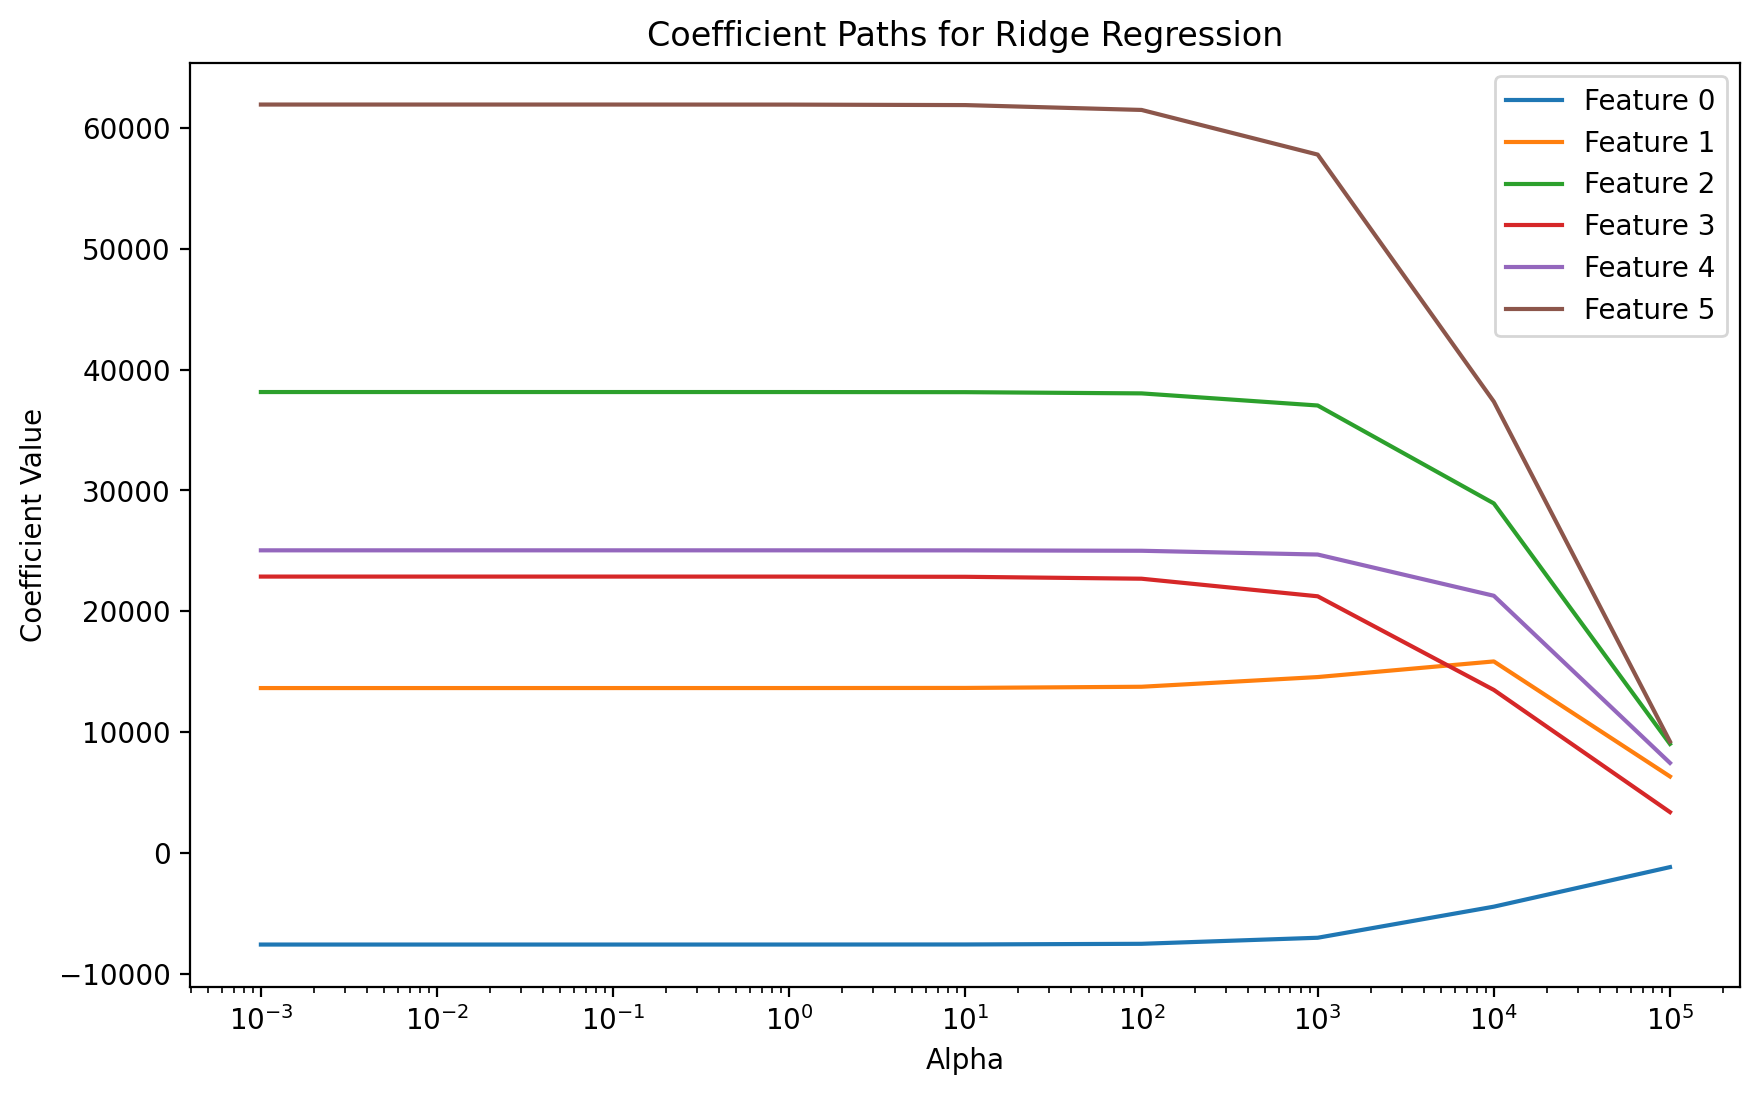

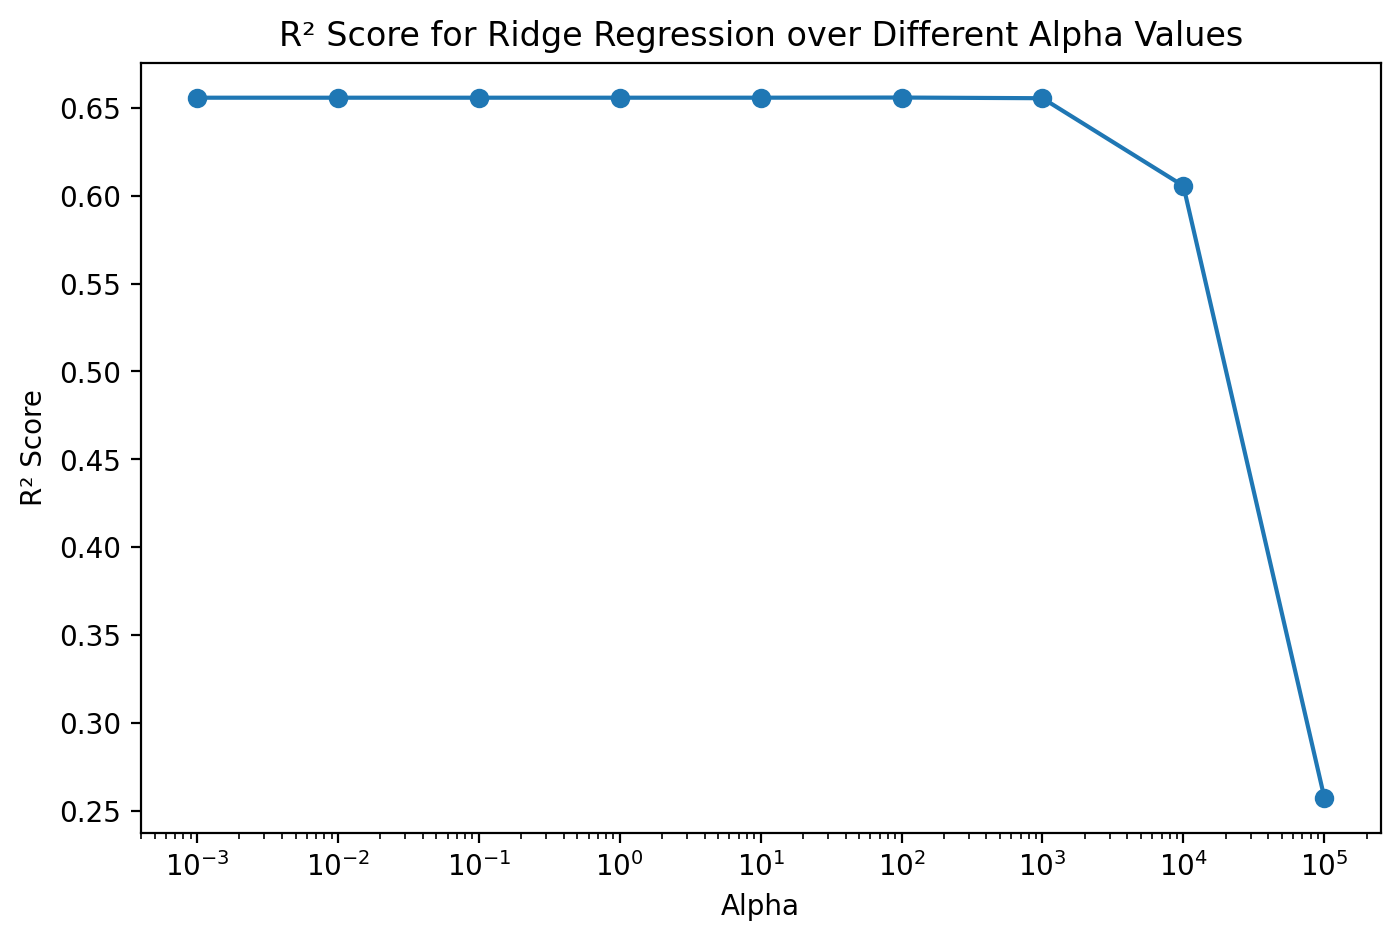

In [26]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
coefs = []
r2s = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(x_train_scaled, y_train)
    coefs.append(ridge.coef_)
    y_pred = ridge.predict(x_valid_scaled)
    r2 = r2_score(y_valid, y_pred)
    r2s.append(r2)
    print(f"Alpha: {a} -> R²: {r2:.4f}, Coefficients: {ridge.coef_}")

# Optionally, visualize how coefficients change with alpha
import matplotlib.pyplot as plt
coefs = np.array(coefs)
plt.figure(figsize=(10,6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f'Feature {i}')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Paths for Ridge Regression')
plt.legend()
plt.show()

# Optionally, plot R² vs alpha
plt.figure(figsize=(8, 5))
plt.plot(alphas, r2s, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score for Ridge Regression over Different Alpha Values')
plt.show()

In [27]:
from sklearn.linear_model import Lasso

# Initialize and fit Lasso regression model
lasso = Lasso(alpha=100)  # Adjust alpha to control sparsity
lasso.fit(x_train_scaled, y_train)

# Predictions
y_pred_lasso = lasso.predict(x_valid_scaled)

# Print selected features (nonzero coefficients)
selected_features = x_train.columns[lasso.coef_ != 0]
print("Selected Features:", selected_features)
print("Lasso Coefficients:", lasso.coef_)

# Compute MSE for Ridge Prediction:
mse_valid_lasso = mean_squared_error(y_valid, y_pred_lasso)

# Print results
print(f"Validation MSE: {mse_valid_lasso:.4f}")

# R Squared
from sklearn.metrics import r2_score
r2 = r2_score(y_valid, y_pred_lasso)
print("R² Score:", r2)

# Adjusted R Squared
n = len(y_valid)
p = X.shape[1]  # number of features

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R²:", adjusted_r2)


Selected Features: Index(['status', 'bed', 'bath', 'acre_lot', 'house_size', 'zip_code_encoded'], dtype='object')
Lasso Coefficients: [-7481.77434277 13603.08111178 38124.28420235 22788.30534061
 25039.39834614 61858.7328151 ]
Validation MSE: 6241685360.5953
R² Score: 0.6556930484435671
Adjusted R²: 0.6548932645839702


Alpha: 0.001 -> R²: 0.6557, Coefficients: [-7576.29607816 13649.80752552 38147.99760717 22875.63497974
 25047.71286916 61940.07437056]
Alpha: 0.01 -> R²: 0.6557, Coefficients: [-7576.28755795 13649.80297919 38147.995531   22875.62710364
 25047.71230331 61940.06706285]
Alpha: 0.1 -> R²: 0.6557, Coefficients: [-7576.20953797 13649.83875388 38148.06173275 22875.56985768
 25047.60920993 61939.95902428]
Alpha: 1 -> R²: 0.6557, Coefficients: [-7575.36489531 13649.55636295 38147.84292426 22874.79368399
 25047.45072328 61939.21590021]
Alpha: 10 -> R²: 0.6557, Coefficients: [-7566.87007707 13646.11952597 38145.1431078  22866.89485419
 25046.52370088 61932.00283155]
Alpha: 100 -> R²: 0.6557, Coefficients: [-7481.77434277 13603.08111178 38124.28420235 22788.30534061
 25039.39834614 61858.7328151 ]
Alpha: 1000 -> R²: 0.6557, Coefficients: [-6630.87750538 13163.86377241 37927.20264731 22003.73449268
 24967.51850301 61123.21279521]
Alpha: 10000 -> R²: 0.6412, Coefficients: [   -0.          8805.2126

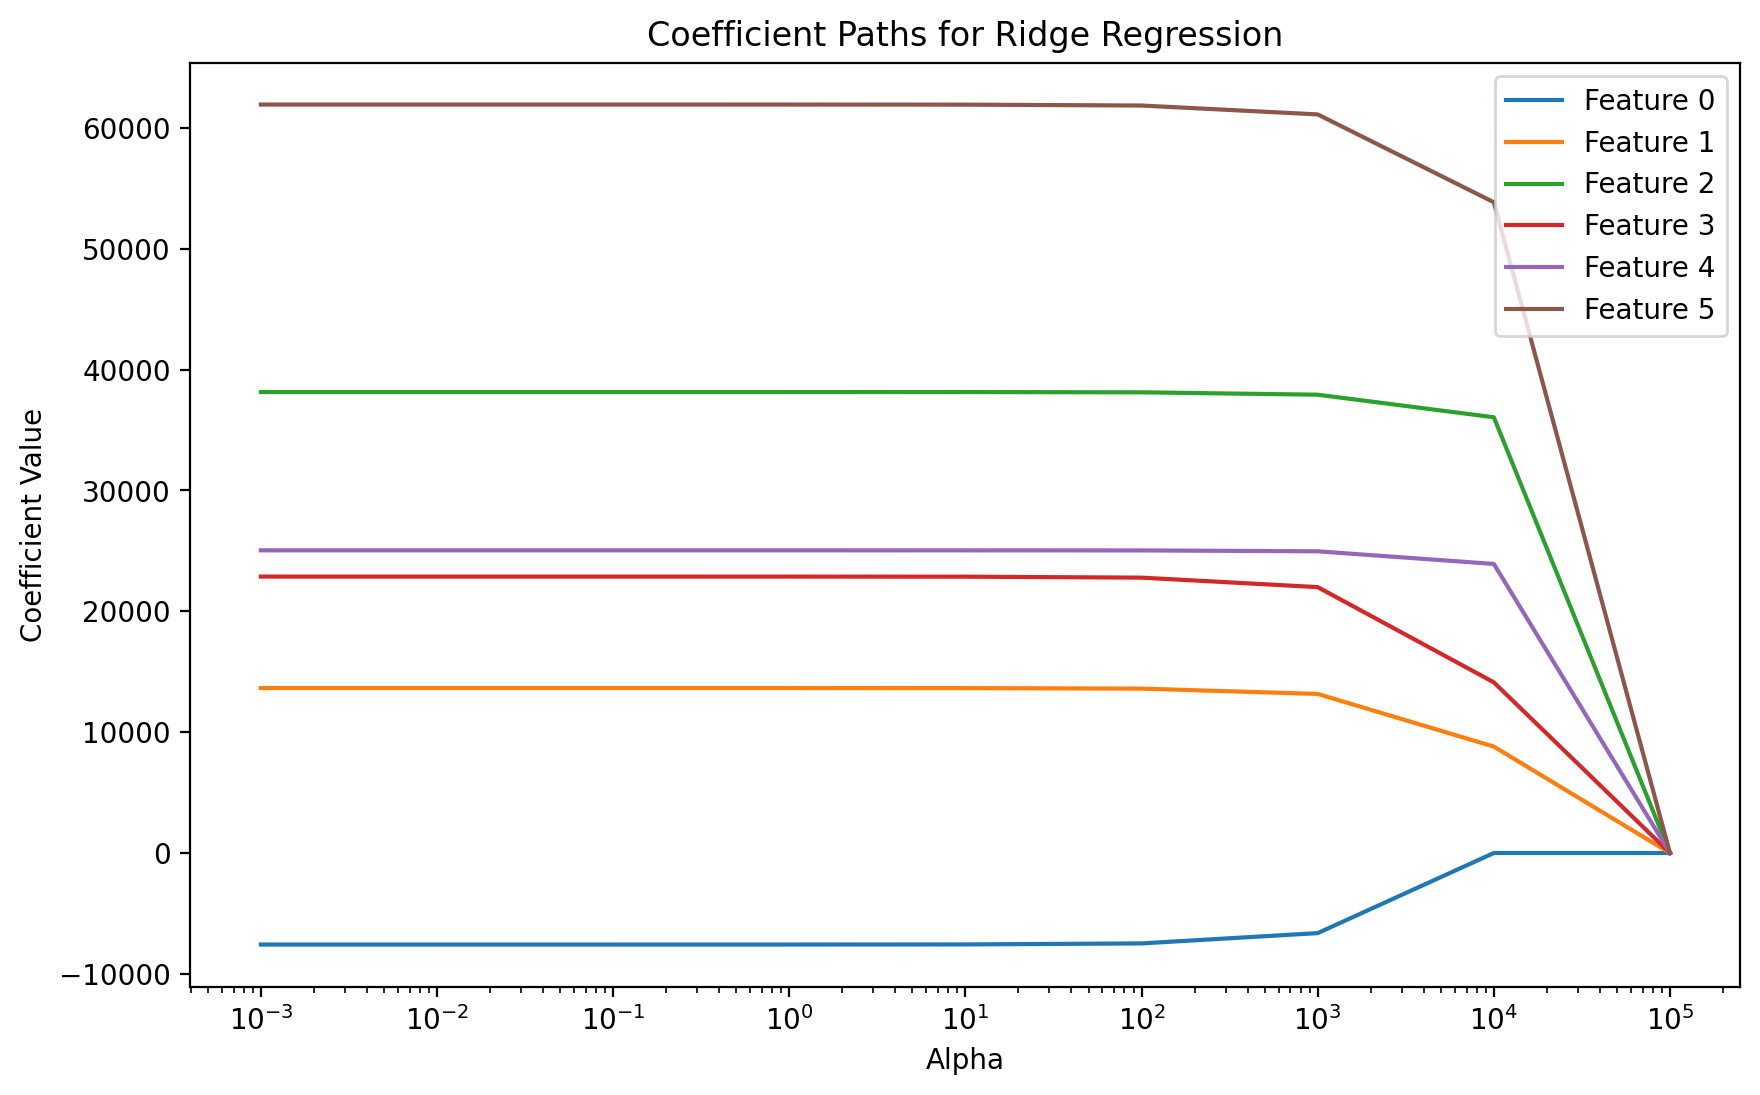

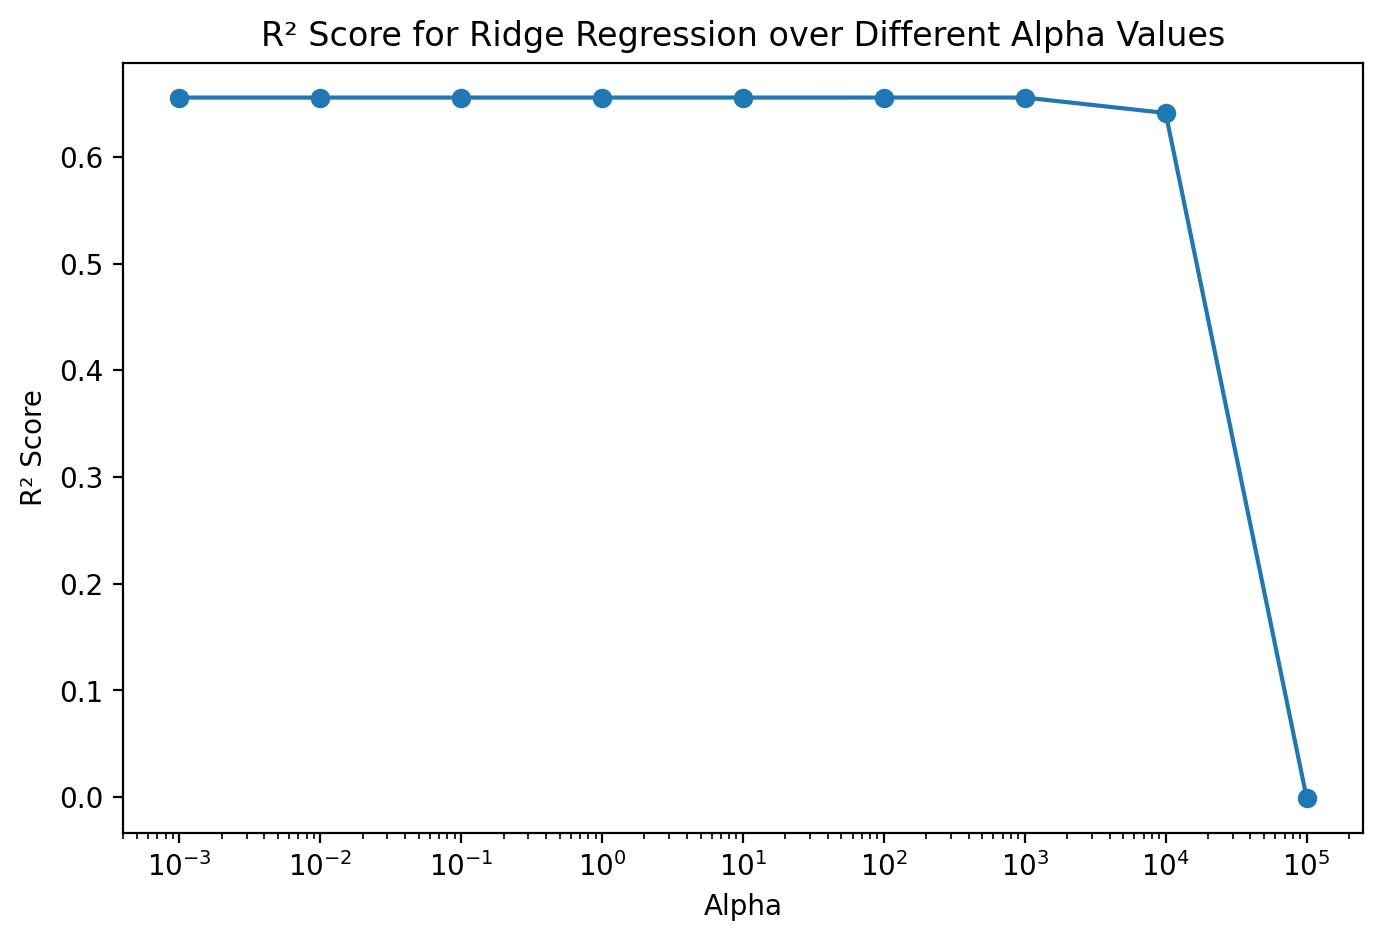

In [28]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
coefs = []
r2s = []



for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)
    y_pred = lasso.predict(x_valid_scaled)
    r2 = r2_score(y_valid, y_pred)
    r2s.append(r2)
    print(f"Alpha: {a} -> R²: {r2:.4f}, Coefficients: {lasso.coef_}")

# Optionally, visualize how coefficients change with alpha
import matplotlib.pyplot as plt
coefs = np.array(coefs)
plt.figure(figsize=(10,6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f'Feature {i}')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Paths for Ridge Regression')
plt.legend()
plt.show()

# Optionally, plot R² vs alpha
plt.figure(figsize=(8, 5))
plt.plot(alphas, r2s, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score for Ridge Regression over Different Alpha Values')
plt.show()

# Bayesian MCMC - Haven't done anything with this yet

In [29]:
with pm.Model() as model1:
    sigma = pm.Exponential('sigma', 1)
    beta1 = pm.Normal('beta1', mu=-0.5, sigma=1)
    beta2 = pm.Normal('beta2', mu=1, sigma=1)
    beta3 = pm.Normal('beta3', mu=0.4, sigma=1)
    beta4 = pm.Normal('beta4', mu=0.3, sigma=1)
    beta5 = pm.Normal('beta5', mu=-2, sigma=1)
    beta6 = pm.Normal('beta6', mu=3.05, sigma=1)
    beta7 = pm.Normal('beta7', mu=-0.05, sigma=1)
    beta8 = pm.Normal('beta8', mu=-3, sigma=1)
    beta9 = pm.Normal('beta9', mu=2.5, sigma=1)
    beta10 = pm.Normal('beta10', mu=-2, sigma=1)
    beta11 = pm.Normal('beta11', mu=-2, sigma=1)
    beta12 = pm.Normal('beta12', mu=0.5, sigma=1)
    beta13 = pm.Normal('beta13', mu=-4, sigma=1)

    alpha = pm.Normal('alpha', mu=0, sigma=1)

    _mu = (alpha + beta1*x_train['CRIM'] + beta2*x_train['ZN']+beta3*x_train['INDUS']+beta4*x_train['CHAS']+beta5*x_train['NOX']+beta6*x_train['RM']+beta7*x_train['AGE']+beta8*x_train['DIS']+beta9*x_train['RAD']+beta10*x_train['TAX']+beta11*x_train['PTRATIO']+beta12*x_train['B']+beta13*x_train['LSTAT'])
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    y_new = pm.Normal('price', mu=mu, sigma=sigma, observed=y_train)
    # (draws=1000, tune=1000, chains=4, return_inferencedata=True)
    _model1_samples = pm.sample(1000, tune=1000, chains=4, return_inferencedata=True)
model1_mcmc_samples = _model1_samples.posterior.to_dataframe()

KeyError: 'CRIM'

In [ ]:
varnames = ['beta1', 'beta2', 'beta3', 'beta4','beta5', 'beta6', 'beta7', 'beta8', 'beta9', 'beta10','beta11', 'beta12', 'beta13', 'sigma', 'alpha']
display(pm.summary(_model1_samples))

In [ ]:
# Set figure size for better readability
figsize = (7, 2 + 0.4 * len(varnames))  # Dynamic height based on variable count

# Trace plot (optional, if needed)
az.plot_trace(_model1_samples, var_names=varnames, compact=False, figsize=(8, 1.6 * len(varnames)))

# Improved Forest Plot
az.plot_forest(
    _model1_samples,
    var_names=varnames,
    combined=True,
    figsize=figsize,
    hdi_prob=0.94,  # Explicitly setting HDI
    ridgeplot_alpha=0.7,  # Slight transparency for better visualization
    markersize=6  # Larger points
)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [ ]:
#import pymc as pm
#import numpy as np

# Assume '_model1_samples' is your posterior trace
posterior_samples = az.extract(_model1_samples)  # Extract samples

# Get posterior means for coefficients
# Instead of 'beta', access individual betas:
beta1_samples = posterior_samples["beta1"]
beta2_samples = posterior_samples["beta2"]
beta3_samples = posterior_samples["beta3"]
beta4_samples = posterior_samples["beta4"]
beta5_samples = posterior_samples["beta5"]
beta6_samples = posterior_samples["beta6"]
beta7_samples = posterior_samples["beta7"]
beta8_samples = posterior_samples["beta8"]
beta9_samples = posterior_samples["beta9"]
beta10_samples = posterior_samples["beta10"]
beta11_samples = posterior_samples["beta11"]
beta12_samples = posterior_samples["beta12"]
beta13_samples = posterior_samples["beta13"]
alpha_samples = posterior_samples["alpha"]  # Intercept

# Stack beta samples into a single array:
beta_samples = np.stack([beta1_samples, beta2_samples, beta3_samples, beta4_samples,
                         beta5_samples, beta6_samples, beta7_samples, beta8_samples,
                         beta9_samples, beta10_samples, beta11_samples, beta12_samples,
                         beta13_samples], axis=-1)

# Predictive function: y = alpha + X * beta
# Convert alpha_samples to a NumPy array and reshape
alpha_samples_np = alpha_samples.values.reshape(-1, 1)

# Reshape x_valid to match expected shape
x_valid_np = x_valid.values

# Calculate predictions for each sample
y_pred_samples = alpha_samples_np + np.dot(beta_samples, x_valid_np.T)

# Compute mean and 94% credible interval
y_pred_mean = y_pred_samples.mean(axis=0)
y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.94)

# Print results
# print("Predicted mean:", y_pred_mean)
# print("94% HDI:", y_pred_hdi)

Tasks:

1. Plot: Prior and posterior distribution of prediction.

2. AIC, abnd BIC:

3. Create a table of beta coefficients - Ridge, Lasso, MCMC


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the mean of the posterior predictive samples
y_pred_mean = y_pred_samples.mean(axis=0)  # Average across posterior samples

# Compute MSE using the mean prediction
mse_valid_mcmc = mean_squared_error(y_valid, y_pred_mean)

# Print results
print(f"Validation MSE: {mse_valid_mcmc:.4f}")